# Clustering on Open Food Facts dataset

### Load data

In [2]:
# Imports libraries
from scripts import analyse_columns, clean
from scripts.kmeans import kmeans_clustering, plot_elbow_method
from scripts.plots import plot_clusters_2d, plot_cluster_sizes, plot_feature_relationships
from scripts.model_utils import load_model
# from scripts.dimension_reduction import reduce_dimensions

import pandas as pd
import numpy as np
# import mlflow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# import umap
import matplotlib.pyplot as plt

# mlflow.autolog()

In [3]:
# Load Open Food Facts dataset csv
path = "data/en.openfoodfacts.org.products.csv"

df = pd.read_csv(path, 
                 sep='\\t', 
                 encoding="utf-8",
                 on_bad_lines='skip',
                 nrows=300000)

C:\Users\jaech\AppData\Local\Temp\ipykernel_16776\4190858480.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path,


In [4]:
# Display basic information about the dataset
print("\nFirst few rows:")
display(df.head())


First few rows:


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,54,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1733085204,2024-12-01T20:33:24Z,NaN,1.740205e+09,2025-02-22T06:23:42Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1673620307,2023-01-13T14:31:47Z,1739902555,2025-02-18T18:15:55Z,waistline-app,1.743267e+09,2025-03-29T16:49:10Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1737247862,2025-01-19T00:51:02Z,smoothie-app,1.743312e+09,2025-03-30T05:22:25Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1743233868,2025-03-29T07:37:48Z,smoothie-app,1.743281e+09,2025-03-29T20:48:12Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1572117743,2019-10-26T19:22:23Z,1738073570,2025-01-28T14:12:50Z,NaN,1.740085e+09,2025-02-20T20:57:12Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Display number of rows and columns
print(df.shape)

(300000, 207)


In [7]:
# Show summary statistics of numeric columns
# Display detailed summary statistics of numeric columns
print("\nSummary statistics of numeric columns:")
print(df.describe(include=[np.number], percentiles=[.05, .25, .5, .75, .95]))

# Show additional statistics
print("\nSkewness of numeric columns:")
print(df.select_dtypes(include=[np.number]).skew())

print("\nKurtosis of numeric columns:")
print(df.select_dtypes(include=[np.number]).kurtosis())

# Count number of non-null values for each numeric column
print("\nNumber of non-null values in numeric columns:")
print(df.select_dtypes(include=[np.number]).count())


Summary statistics of numeric columns:
               code     created_t  last_modified_t  last_updated_t  cities  \
count  3.000000e+05  3.000000e+05     3.000000e+05    2.999990e+05     0.0   
mean   3.137336e+10  1.602221e+09     1.675281e+09    1.730084e+09     NaN   
std    1.790903e+10  7.941908e+07     6.019029e+07    1.264524e+07     NaN   
min    1.000000e+00  1.332445e+09     1.424628e+09    1.701775e+09     NaN   
5%     3.751437e+05  1.489060e+09     1.587584e+09    1.707823e+09     NaN   
25%    1.586902e+10  1.537557e+09     1.627337e+09    1.720854e+09     NaN   
50%    3.582620e+10  1.592158e+09     1.686268e+09    1.734786e+09     NaN   
75%    4.222213e+10  1.660326e+09     1.728055e+09    1.738831e+09     NaN   
95%    5.974993e+10  1.726980e+09     1.740369e+09    1.742519e+09     NaN   
max    6.263936e+10  1.743488e+09     1.743488e+09    1.743488e+09     NaN   

       allergens_en  serving_quantity    additives_n  additives  \
count           0.0      1.740800e

### Data Processing

In [8]:
# Keep only relevant columns (nutritional columns)

# All other columns are irrelevant
irrelevant_columns = [col for col in df.columns if not col.endswith('_100g')]

# Manually remove energy-kcal_100g and fat_100g from irrelevant_columns
irrelevant_columns.extend(['energy-kcal_100g', 'fat_100g'])


# Clean dataset using the clean() function
df_cleaned = clean.clean(df, irrelevant_columns=irrelevant_columns, missing_threshold=0.5)

# Display cleaned dataset info
print("\nCleaned dataset shape:", df.shape)
print("\nRemaining columns:")
print(df_cleaned.columns.tolist())



Cleaned dataset shape: (300000, 207)

Remaining columns:
['energy_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


In [9]:
display(df_cleaned.head())

,energy_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1389.0,17.3,3.0,1.0,NaN,23.0,1.200,0.48,0.000000
2,2415.0,28.0,30.0,27.0,NaN,7.1,0.025,0.01,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011335


In [10]:
# Handle missing values by filling with median for numeric columns
# Using median instead of mean to be more robust to outliers
df_cleaned = df_cleaned.fillna(df_cleaned.median())

# Verify no more NaN values exist
print("\nNumber of NaN values remaining:")
print(df_cleaned.isna().sum().sum())

# Display first few rows to verify changes
print("\nFirst few rows after handling missing values:")
display(df_cleaned.head())

print("\nShape")
print(df_cleaned.shape)



Number of NaN values remaining:
0

First few rows after handling missing values:


,energy_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,1130.0,1.5,23.0,5.263158,1.41,5.0,0.435,0.174,0.670268
1,1389.0,17.3,3.0,1.000000,1.41,23.0,1.200,0.480,0.000000
2,2415.0,28.0,30.0,27.000000,1.41,7.1,0.025,0.010,0.670268
3,1130.0,1.5,23.0,5.263158,1.41,5.0,0.435,0.174,100.000000
4,1130.0,1.5,23.0,5.263158,1.41,5.0,0.435,0.174,0.011335



Shape
(300000, 9)


In [11]:
# Scale features using StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_cleaned),
    columns=df_cleaned.columns
)

# Display first few rows of scaled data
print("First few rows of scaled data:")
display(df_scaled.head())

# Verify scaling - mean should be ~0 and std should be ~1
print("\nMean of scaled features:")
print(df_scaled.mean().round(2))
print("\nStandard deviation of scaled features:")
print(df_scaled.std().round(2))



First few rows of scaled data:


,energy_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,-0.132443,-0.128699,-0.241186,-0.276767,-0.061343,-0.167041,-0.001826,-0.001826,-0.397388
1,-0.013832,0.449043,-0.540719,-0.378831,-0.061343,0.625166,-0.001826,-0.001826,-0.425239
2,0.456029,0.840298,-0.136349,0.243635,-0.061343,-0.074617,-0.001826,-0.001826,-0.397388
3,-0.132443,-0.128699,-0.241186,-0.276767,-0.061343,-0.167041,-0.001826,-0.001826,3.730039
4,-0.132443,-0.128699,-0.241186,-0.276767,-0.061343,-0.167041,-0.001826,-0.001826,-0.424768



Mean of scaled features:
energy_100g                                             -0.0
saturated-fat_100g                                       0.0
carbohydrates_100g                                      -0.0
sugars_100g                                              0.0
fiber_100g                                              -0.0
proteins_100g                                           -0.0
salt_100g                                                0.0
sodium_100g                                             -0.0
fruits-vegetables-nuts-estimate-from-ingredients_100g   -0.0
dtype: float64

Standard deviation of scaled features:
energy_100g                                              1.0
saturated-fat_100g                                       1.0
carbohydrates_100g                                       1.0
sugars_100g                                              1.0
fiber_100g                                               1.0
proteins_100g                                            1.0
salt

In [12]:
# Remove outliers using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for values within bounds
    mask = ~((df < lower_bound) | (df > upper_bound)).any(axis=1)
    
    return df[mask]

# Remove outliers and store in new DataFrame
print("Shape before removing outliers:", df_scaled.shape)
df_scaled_no_outliers = remove_outliers(df_scaled)
print("Shape after removing outliers:", df_scaled_no_outliers.shape)
print(f"Removed {df_scaled.shape[0] - df_scaled_no_outliers.shape[0]} outliers")

# Update original data without outliers for consistency
df_cleaned = df_cleaned.loc[df_scaled_no_outliers.index]


Shape before removing outliers: (300000, 9)
Shape after removing outliers: (146881, 9)
Removed 153119 outliers


In [11]:
# Create cleaned dataset


### Feature Engineering

In [12]:
# Create new features


Taking a sample of 10000 rows for PCA visualization...
Performing PCA...
Explained variance ratio: [9.99078477e-01 7.18159776e-04]
Cumulative explained variance ratio: [0.99907848 0.99979664]
Creating visualization plots...


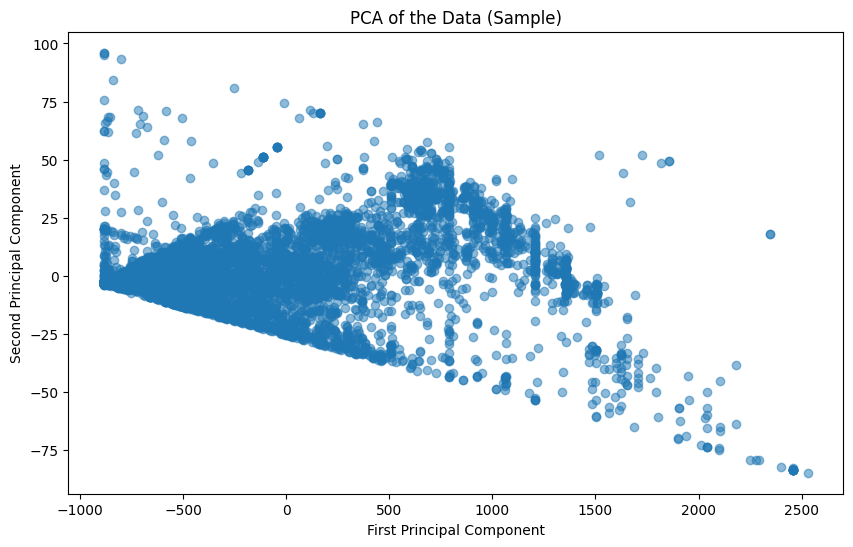

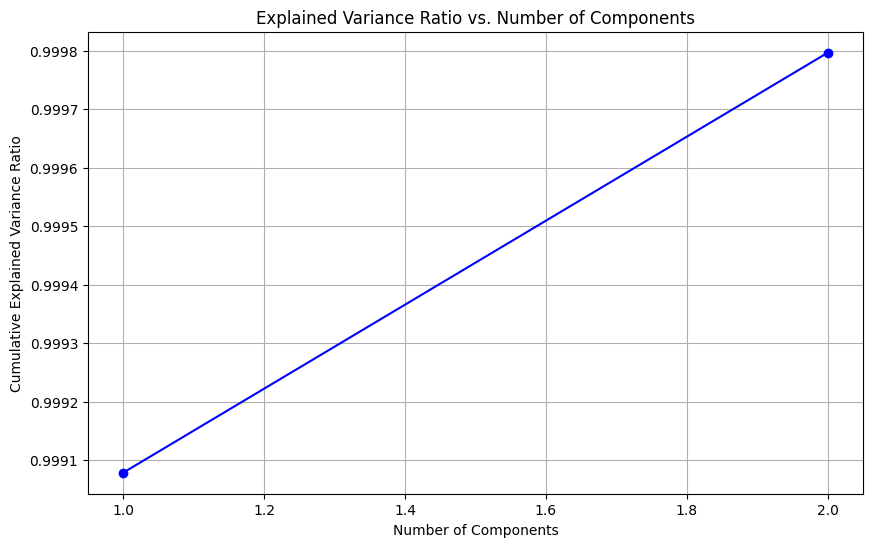

In [17]:
# Take a smaller sample for visualization (10,000 rows)
sample_size = 10000
print(f"Taking a sample of {sample_size} rows for PCA visualization...")
df_sample = df_cleaned.sample(n=sample_size, random_state=42)

# Initialize PCA with 2 components for visualization
print("Performing PCA...")
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_sample.values)

# Calculate explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', np.cumsum(pca.explained_variance_ratio_))

# Plot PCA results
print("Creating visualization plots...")
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of the Data (Sample)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [14]:
# Analyze feature importance and correlations


### Clustering Analysis

In [ ]:
# ### Dimensionality Reduction
# print("Original data shape:", df_cleaned.shape)

# # Apply UMAP reduction
# reduced_data = reduce_dimensions(df_cleaned.values)
# print("Reduced data shape:", reduced_data.shape)

# # Visualize the reduced data
# plt.figure(figsize=(10, 6))
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
# plt.title('UMAP Projection of the Data')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.show()

- #### K-Means

In [14]:
# Determine optimal number of clusters
plot_elbow_method(reduced_data)

NameError: name 'reduced_data' is not defined

In [ ]:
# Perform clustering
kmeans, labels, metrics = kmeans_clustering(reduced_data)

In [ ]:
# Plot clusters in the reduced space
plot_clusters_2d(reduced_data, labels, 
                title="K-means Clustering Results on UMAP Reduced Data")

In [ ]:
# Show cluster sizes
plot_cluster_sizes(labels)

In [ ]:
### Feature Analysis
# Create feature relationship plots using original data
feature_names = df_cleaned.columns.tolist()
plot_feature_relationships(
    data=df_cleaned.values,  # Using original data, not reduced_data
    labels=labels,
    feature_names=feature_names,
    n_features=5  # Adjust based on how many features you want to compare
)

In [16]:
# First, plot elbow method to determine optimal number of clusters
print("Plotting elbow method...")
plot_elbow_method(pca_result)

# Perform K-means clustering
print("Performing K-means clustering...")
kmeans, labels, metrics = kmeans_clustering(pca_result)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                     c=labels, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering on PCA Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# Print cluster sizes
print("\nCluster sizes:")
for i in range(len(np.unique(labels))):
    print(f"Cluster {i}: {np.sum(labels == i)} samples")

# Print additional metrics
print("\nClustering metrics:")
print(f"Inertia: {metrics['inertia']:.2f}")
print(f"Number of iterations: {metrics['n_iter']}")

NameError: name 'KMeans' is not defined

In [21]:
# DBSCAN clustering

In [22]:
# Gaussian Mixture Model (GMM) clustering


In [23]:
# Hierarchical clustering


### Cluster evaluation and comparison

In [24]:
# Compare clustering results using metrics (Silhouette score, Calinski-Harabasz index, Davies-Bouldin index)

In [25]:
# Visualize cluster comparisons (word clouds, ...)

In [26]:
# Analyse cluster characteristics and interpret results

### Visualization and Insights

In [27]:
# Various visualizations (cluster distribution plots, feature importance within clusters, pairplots with key features, heatmaps of cluster characteristics)


In [28]:
# Generate insights about food product groupings

In [29]:
# Indentify patterns and trends in the clusters

### Conclusions and recommendations

In [30]:
# Summarize findings


In [31]:
# Compare strengths and weaknesses of different clustering methods


In [32]:
# Provide recommendations for practical applications


In [33]:
#Suggest potential areas for futher analysis